In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Seed for reproducibility
np.random.seed(42)

# Simulate data
n_samples = 200
Size = np.random.normal(2000, 400, n_samples)     # in sqft
Bedrooms = np.random.randint(2, 6, n_samples)     # 2 to 5 bedrooms
Bathrooms = np.random.randint(1, 4, n_samples)    # 1 to 3 bathrooms
Garage = np.random.randint(0, 3, n_samples)       # 0 to 2 car garage
Age = np.random.randint(0, 50, n_samples)         # house age in years

# True coefficients for house price (per realistic assumptions)
beta0 = 50000       # base price
beta_size = 150     # $ per sqft
beta_bedrooms = 10000
beta_bathrooms = 12000
beta_garage = 8000
beta_age = -1000    # depreciation per year

# Simulate house price with noise
noise = np.random.normal(0, 20000, n_samples)
Price = (beta0 + beta_size*Size + beta_bedrooms*Bedrooms + beta_bathrooms*Bathrooms +
         beta_garage*Garage + beta_age*Age + noise)

# Create DataFrame
df = pd.DataFrame({
    'Price': Price,
    'Size': Size,
    'Bedrooms': Bedrooms,
    'Bathrooms': Bathrooms,
    'Garage': Garage,
    'Age': Age
})


In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [26]:
X = df[['Size', 'Bedrooms', 'Bathrooms', 'Garage', 'Age']]
y = df['Price']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
# Initialize and fit Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

In [29]:
# Coefficients
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_model.coef_
})

print(coefficients)
print(f"Intercept: {lr_model.intercept_:.2f}")

     Feature   Coefficient
0       Size    141.179964
1   Bedrooms   7879.827643
2  Bathrooms  12278.865691
3     Garage  10824.925412
4        Age   -962.382668
Intercept: 70599.68


In [30]:
# Predict on test data
y_pred = lr_model.predict(X_test)

# Metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Test R-squared: {r2:.4f}")
print(f"Test RMSE: ${rmse:,.2f}")

Test R-squared: 0.8842
Test RMSE: $18,044.99


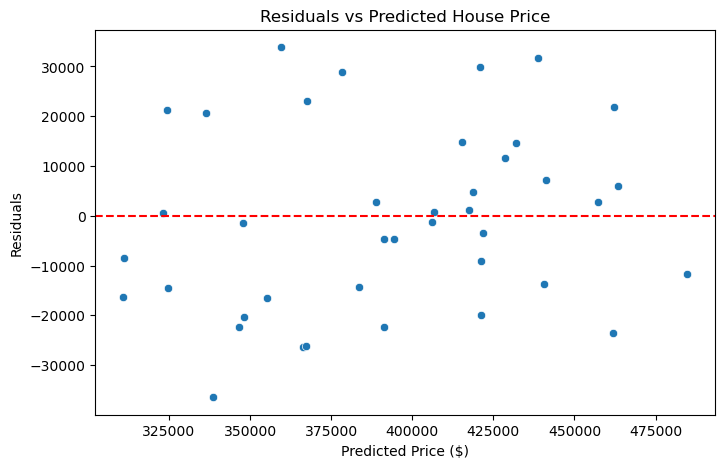

In [31]:
residuals = y_test - y_pred

plt.figure(figsize=(8,5))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted House Price")
plt.xlabel("Predicted Price ($)")
plt.ylabel("Residuals")
plt.show()

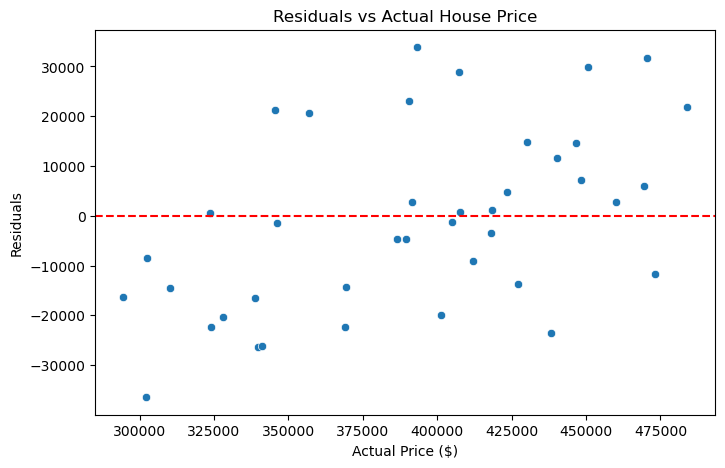

In [32]:
residuals = y_test - y_pred

plt.figure(figsize=(8,5))
sns.scatterplot(x=y_test, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Actual House Price")
plt.xlabel("Actual Price ($)")
plt.ylabel("Residuals")
plt.show()

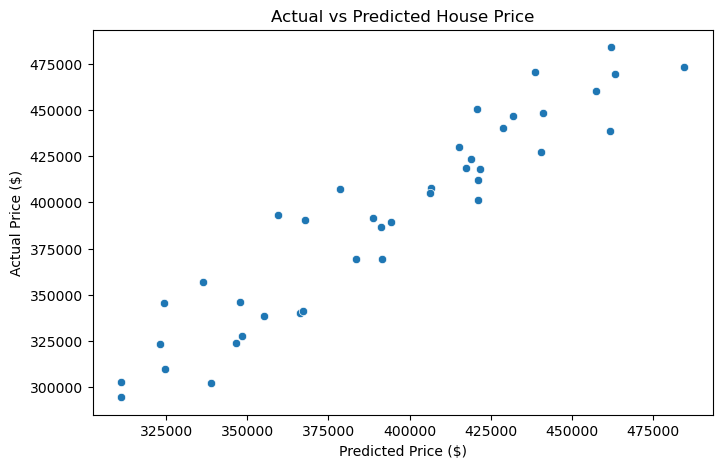

In [33]:
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_pred, y=y_test)
plt.title("Actual vs Predicted House Price")
plt.xlabel("Predicted Price ($)")
plt.ylabel("Actual Price ($)")
plt.show()

In [34]:
from sklearn.utils import resample

# Assume X_train, y_train are already defined from previous steps

# Bootstrapping for confidence intervals
n_bootstraps = 1000
coefs = []

for _ in range(n_bootstraps):
    X_sample, y_sample = resample(X_train, y_train)
    model = LinearRegression().fit(X_sample, y_sample)
    coefs.append(model.coef_)

coefs = np.array(coefs)

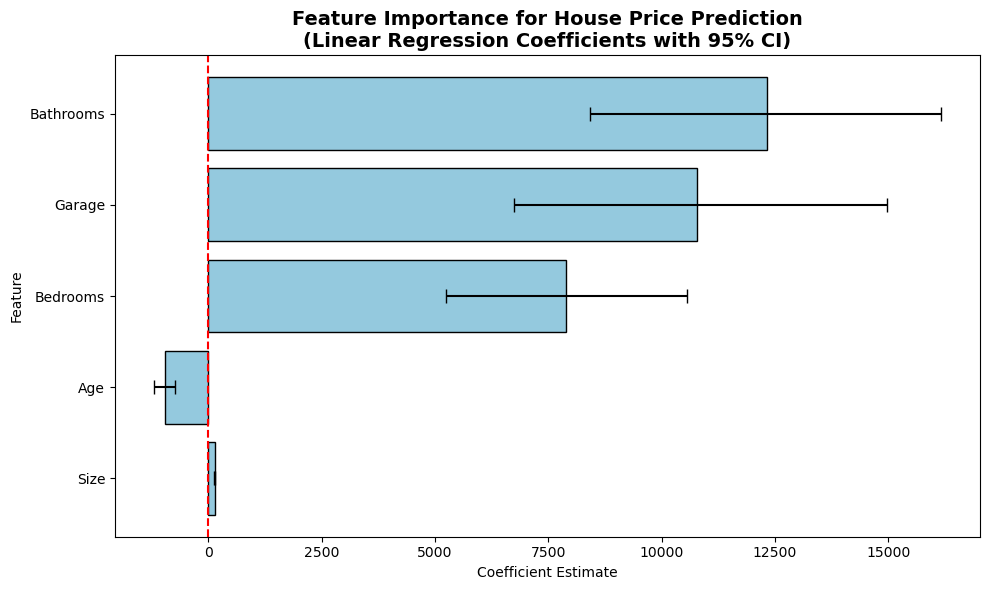

In [35]:
coef_mean = np.mean(coefs, axis=0)
coef_lower = np.percentile(coefs, 2.5, axis=0)
coef_upper = np.percentile(coefs, 97.5, axis=0)

# Prepare DataFrame
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coef_mean,
    'CI Lower': coef_lower,
    'CI Upper': coef_upper
}).sort_values(by='Coefficient', key=abs, ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coef_df, color='skyblue', edgecolor='black')

# Error bars (CI)
plt.errorbar(coef_df['Coefficient'], coef_df['Feature'],
             xerr=[coef_df['Coefficient'] - coef_df['CI Lower'], coef_df['CI Upper'] - coef_df['Coefficient']],
             fmt='none', ecolor='black', capsize=5)

plt.title("Feature Importance for House Price Prediction\n(Linear Regression Coefficients with 95% CI)", fontsize=14, fontweight="bold")
plt.xlabel("Coefficient Estimate")
plt.ylabel("Feature")
plt.axvline(0, color='red', linestyle='--')
plt.tight_layout()
plt.show()

In [36]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

In [37]:
# Define Ridge regression with CV for best alpha (regularization strength)
ridge = Ridge()

# Search over a range of alpha values
param_grid = {'alpha': np.logspace(-3, 3, 20)}

ridge_cv = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error')
ridge_cv.fit(X_train, y_train)

# Best alpha value
best_alpha = ridge_cv.best_params_['alpha']
print(f"Best alpha from CV: {best_alpha}")


Best alpha from CV: 2.976351441631316


In [38]:
# Fit final Ridge model with best alpha
ridge_model = Ridge(alpha=best_alpha)
ridge_model.fit(X_train, y_train)

# Coefficients
ridge_coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': ridge_model.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

print(ridge_coef_df)
print(f"Intercept: {ridge_model.intercept_:.2f}")

     Feature   Coefficient
2  Bathrooms  11959.159276
3     Garage  10516.148445
1   Bedrooms   7744.285307
4        Age   -963.142679
0       Size    141.240333
Intercept: 71870.53


In [39]:
# Predictions on test data
y_pred_ridge = ridge_model.predict(X_test)

# R2 and RMSE
ridge_r2 = r2_score(y_test, y_pred_ridge)
ridge_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ridge))

print(f"Ridge R-squared: {ridge_r2:.4f}")
print(f"Ridge RMSE: ${ridge_rmse:,.2f}")


Ridge R-squared: 0.8848
Ridge RMSE: $18,000.79


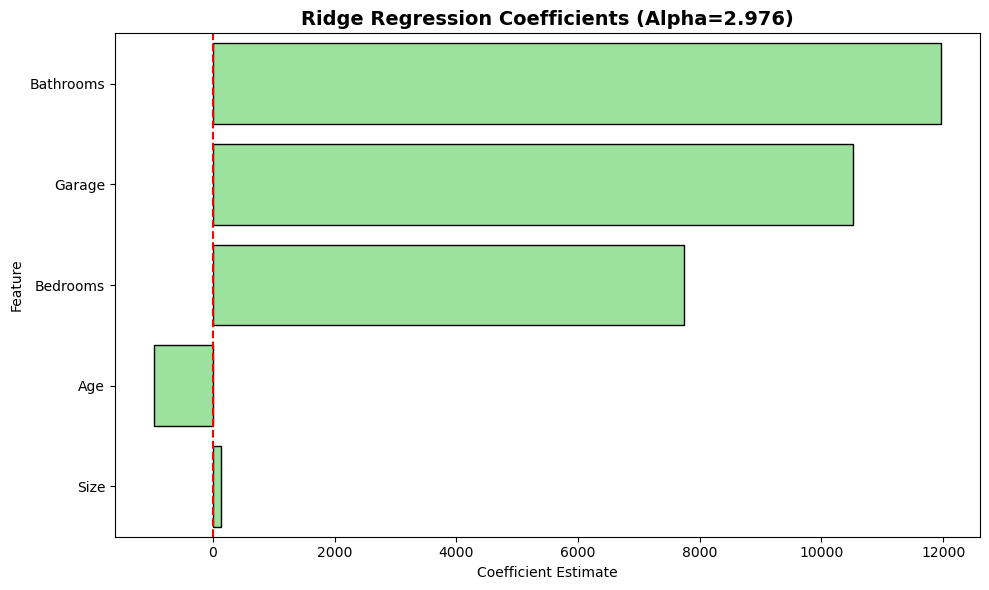

In [40]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=ridge_coef_df, color='lightgreen', edgecolor='black')
plt.title(f"Ridge Regression Coefficients (Alpha={best_alpha:.3f})", fontsize=14, fontweight="bold")
plt.xlabel("Coefficient Estimate")
plt.axvline(0, color='red', linestyle='--')
plt.tight_layout()
plt.show()

In [41]:
# OLS coefficients (from scikit-learn LinearRegression)
ols_model = LinearRegression()
ols_model.fit(X_train, y_train)

# Create DataFrame for OLS and Ridge Coefficients
comparison_df = pd.DataFrame({
    'Feature': X.columns,
    'OLS Coef': ols_model.coef_,
    'Ridge Coef': ridge_model.coef_
}).melt(id_vars='Feature', var_name='Model', value_name='Coefficient')


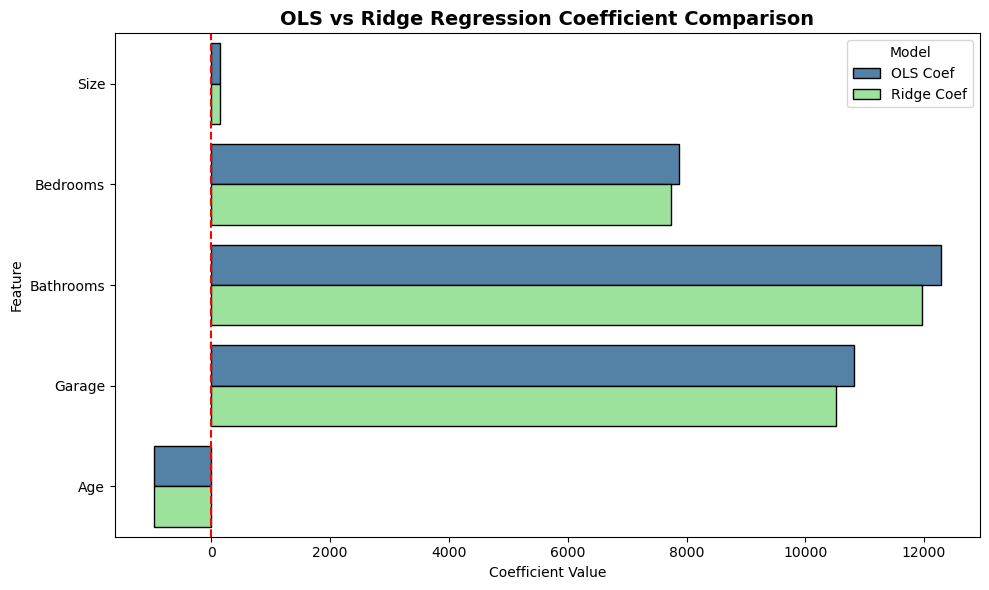

In [42]:
plt.figure(figsize=(10, 6))
sns.barplot(data=comparison_df, x='Coefficient', y='Feature', hue='Model', palette=['steelblue', 'lightgreen'], edgecolor='black')

plt.title("OLS vs Ridge Regression Coefficient Comparison", fontsize=14, fontweight="bold")
plt.axvline(0, color='red', linestyle='--')
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.legend(title="Model", loc="best")
plt.tight_layout()
plt.show()

In [43]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

# Define Lasso regression with cross-validation for alpha selection
lasso = Lasso(max_iter=10000)

# Search over a range of alpha values (same as Ridge)
param_grid = {'alpha': np.logspace(-3, 3, 20)}

lasso_cv = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error')
lasso_cv.fit(X_train, y_train)

# Best alpha for Lasso
best_alpha_lasso = lasso_cv.best_params_['alpha']
print(f"Best alpha for Lasso: {best_alpha_lasso}")

Best alpha for Lasso: 112.88378916846884


In [44]:
# Fit Lasso model with best alpha
lasso_model = Lasso(alpha=best_alpha_lasso, max_iter=10000)
lasso_model.fit(X_train, y_train)

# Coefficients
print(pd.Series(lasso_model.coef_, index=X.columns))

Size           141.218619
Bedrooms      7778.504096
Bathrooms    12116.181826
Garage       10644.157007
Age           -962.189742
dtype: float64


In [45]:
# Combine coefficients into a single DataFrame
comparison_df = pd.DataFrame({
    'Feature': X.columns,
    'OLS Coef': ols_model.coef_,
    'Ridge Coef': ridge_model.coef_,
    'Lasso Coef': lasso_model.coef_
}).melt(id_vars='Feature', var_name='Model', value_name='Coefficient')


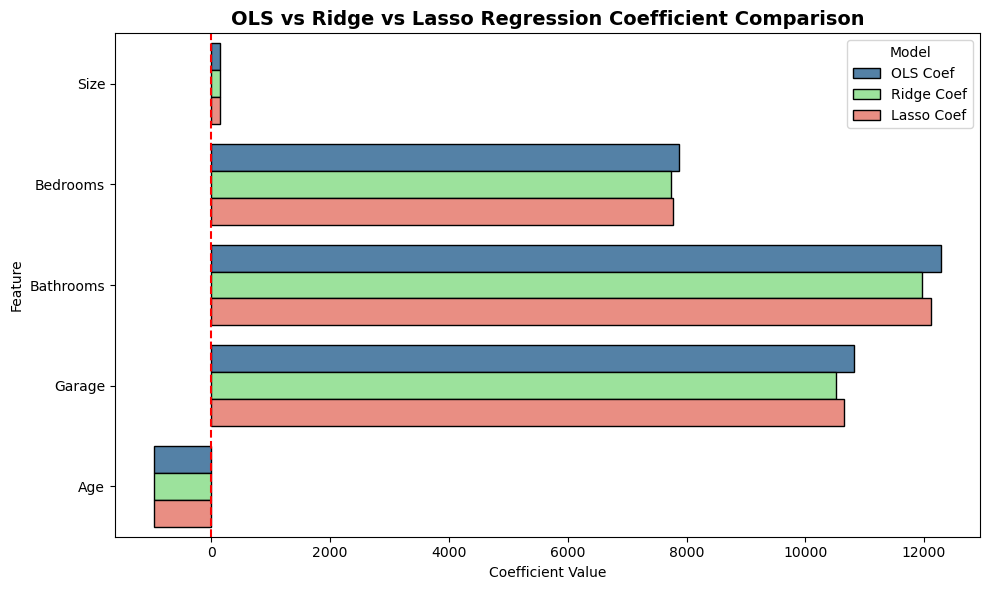

In [46]:
plt.figure(figsize=(10, 6))
sns.barplot(data=comparison_df, x='Coefficient', y='Feature', hue='Model', palette=['steelblue', 'lightgreen', 'salmon'], edgecolor='black')

plt.title("OLS vs Ridge vs Lasso Regression Coefficient Comparison", fontsize=14, fontweight="bold")
plt.axvline(0, color='red', linestyle='--')
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.legend(title="Model", loc="best")
plt.tight_layout()
plt.show()


In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso

# Ensure X_train and y_train are defined from previous steps
alphas = np.logspace(-3, 3, 100)


In [48]:
ridge_coefs = []

# Train Ridge for each alpha and store coefficients
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    ridge_coefs.append(ridge.coef_)

ridge_coefs = np.array(ridge_coefs)


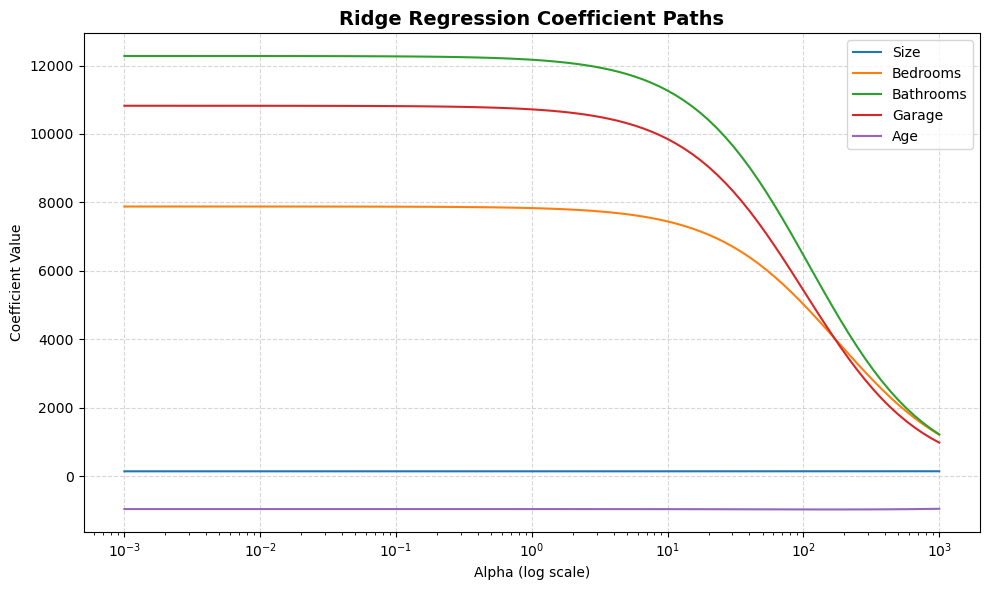

In [49]:
plt.figure(figsize=(10, 6))
for i, feature in enumerate(X.columns):
    plt.plot(alphas, ridge_coefs[:, i], label=feature)

plt.xscale('log')
plt.xlabel('Alpha (log scale)')
plt.ylabel('Coefficient Value')
plt.title('Ridge Regression Coefficient Paths', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [50]:
lasso_coefs = []

# Train Lasso for each alpha and store coefficients
for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_train, y_train)
    lasso_coefs.append(lasso.coef_)

lasso_coefs = np.array(lasso_coefs)


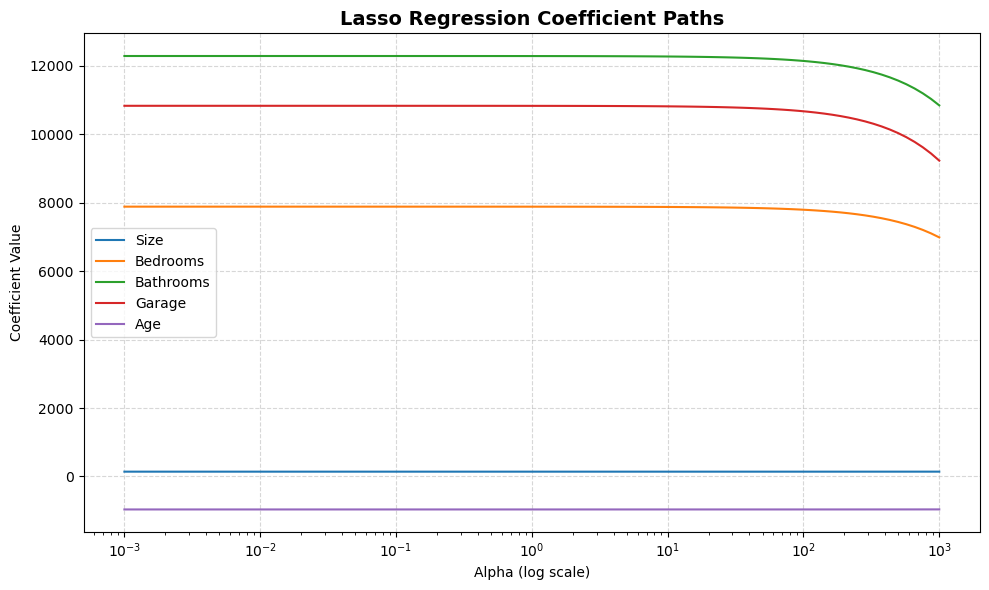

In [51]:
plt.figure(figsize=(10, 6))
for i, feature in enumerate(X.columns):
    plt.plot(alphas, lasso_coefs[:, i], label=feature)

plt.xscale('log')
plt.xlabel('Alpha (log scale)')
plt.ylabel('Coefficient Value')
plt.title('Lasso Regression Coefficient Paths', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [52]:
from sklearn.metrics import r2_score, mean_squared_error

# OLS predictions
y_pred_ols = ols_model.predict(X_test)
ols_r2 = r2_score(y_test, y_pred_ols)
ols_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ols))

# Ridge predictions
y_pred_ridge = ridge_model.predict(X_test)
ridge_r2 = r2_score(y_test, y_pred_ridge)
ridge_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ridge))

# Lasso predictions
y_pred_lasso = lasso_model.predict(X_test)
lasso_r2 = r2_score(y_test, y_pred_lasso)
lasso_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lasso))


In [53]:
# Collect Coefficients for comparison
comparison_table = pd.DataFrame({
    'Feature': X.columns,
    'OLS Coef': ols_model.coef_,
    'Ridge Coef': ridge_model.coef_,
    'Lasso Coef': lasso_model.coef_
})

# Add Performance Metrics Row
metrics_df = pd.DataFrame({
    'Feature': ['R-squared', 'RMSE'],
    'OLS Coef': [ols_r2, ols_rmse],
    'Ridge Coef': [ridge_r2, ridge_rmse],
    'Lasso Coef': [lasso_r2, lasso_rmse]
})

# Combine into final summary table
final_summary = pd.concat([comparison_table, metrics_df], ignore_index=True)

# Round for readability
final_summary[['OLS Coef', 'Ridge Coef', 'Lasso Coef']] = final_summary[['OLS Coef', 'Ridge Coef', 'Lasso Coef']].round(2)

# Display the summary
print(final_summary)


     Feature  OLS Coef  Ridge Coef  Lasso Coef
0       Size    141.18      141.24      141.22
1   Bedrooms   7879.83     7744.29     7778.50
2  Bathrooms  12278.87    11959.16    12116.18
3     Garage  10824.93    10516.15    10644.16
4        Age   -962.38     -963.14     -962.19
5  R-squared      0.88        0.88        0.88
6       RMSE  18044.99    18000.79    18011.23


In [54]:
import statsmodels.api as sm

# Add constant term to X
X_const = sm.add_constant(X_train)

# Fit OLS model using statsmodels
ols_sm = sm.OLS(y_train, X_const).fit()

# Display OLS summary with p-values
print(ols_sm.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     233.0
Date:                Thu, 15 May 2025   Prob (F-statistic):           6.58e-70
Time:                        13:55:29   Log-Likelihood:                -1818.7
No. Observations:                 160   AIC:                             3649.
Df Residuals:                     154   BIC:                             3668.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        7.06e+04    1.2e+04      5.908      0.0